In [22]:
import pandas as pd
from druxai.utils.evaluation import check_shared_cells
from scipy.stats import spearmanr
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random


In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
# Define the folder path where the CSV files are located
folder_path = "/Users/niklaskiermeyer/Desktop/Codespace/DruxAI/results/slurm/cv_baseline/predictions/"
fold_results = {}

# Loop through each fold
for file in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    fold_results[file] = df

In [5]:
# Check if cell-lines exist in different folds
check_shared_cells(fold_results)

'No shared cells found across folds.'

In [6]:
# Overall R Score per Fold
overall_mean_rscore = []
for key in fold_results:
    fold_r_scores = []  # Initialize a list to store R scores for the current fold
    r_value, _ = spearmanr(fold_results[key]["prediction"], fold_results[key]["ground_truth"])
    overall_mean_rscore.append(r_value)
    print(f"Fold {key} - Mean R Score: {r_value}")

print("Cross Fold Mean R Score: ", sum(overall_mean_rscore) / len(overall_mean_rscore))

Fold prediction_fold_3_epoch_10.csv - Mean R Score: 0.05700257908480753
Fold prediction_fold_2_epoch_43.csv - Mean R Score: 0.11417812052671303
Fold prediction_fold_1_epoch_10.csv - Mean R Score: 0.10032480612441587
Cross Fold Mean R Score:  0.09050183524531213


In [7]:
entire_dataset_rscores = []  # Initialize a DataFrame to store the R scores for the entire dataset

for key in fold_results:
    fold_r_scores = []  # Initialize a list to store R scores for the current fold
    for group_name, group_data in fold_results[key].groupby("drugs"):
        r_value, _ = spearmanr(group_data["prediction"], group_data["ground_truth"])
        fold_r_scores.append({"Group": group_name, "Mean Drug R Score": r_value})
    entire_dataset_rscores.extend(fold_r_scores)
    fold_mean_r_score = pd.DataFrame(fold_r_scores)["Mean Drug R Score"].mean()
    print(f"Fold {key} - Mean R Score per drug: {fold_mean_r_score}")

entire_dataset_rscores = pd.DataFrame(entire_dataset_rscores).groupby("Group").mean().sort_values("Mean Drug R Score"
                                                                                                  , ascending=False)
print(" \n Overall per drug mean R Score:", entire_dataset_rscores["Mean Drug R Score"].mean())

Fold prediction_fold_3_epoch_10.csv - Mean R Score per drug: 0.05343402142875978
Fold prediction_fold_2_epoch_43.csv - Mean R Score per drug: 0.10565943529382814
Fold prediction_fold_1_epoch_10.csv - Mean R Score per drug: 0.09520155252820654
 
 Overall per drug mean R Score: 0.08476500308359815


In [11]:
num_groups = len(entire_dataset_rscores[entire_dataset_rscores["Mean Drug R Score"] > 0.2])
print("Number of groups with mean drug R score over 0.2:", num_groups)


Number of groups with mean drug R score over 0.2: 123


In [12]:
entire_dataset_rscores[entire_dataset_rscores["Mean Drug R Score"] > 0.2]

,Mean Drug R Score
Group,
AZ960,0.340754
PARBENDAZOLE,0.330607
ARIPIPRAZOLE,0.319048
PU-H71,0.316243
VINDESINE,0.309227
...,...
AMONAFIDE,0.202384
SN-38,0.202283
VLX600,0.201943


In [23]:
entire_dataset_rscores.tail(5)

,Mean Drug R Score
Group,
PHLORIZIN,-0.119045
HYDROCORTISONE,-0.122630
CHIR-98014,-0.135790
METOPROLOL,-0.136186
TYRPHOSTIN-AG-494,-0.145125


In [24]:
# Get all the results from the CV which are stored in fold_results
all_results = pd.concat(fold_results.values()).reset_index(drop=True)

# Set the random seed for reproducibility
random.seed(432)

number_drugs = 10 # Number of drugs to select

# Select l drugs randomly
selected_drugs = random.sample(all_results["drugs"].unique().tolist(), number_drugs)

# Filter the observations based on the selected drugs
subset_results_val = all_results[all_results["drugs"].isin(selected_drugs)]

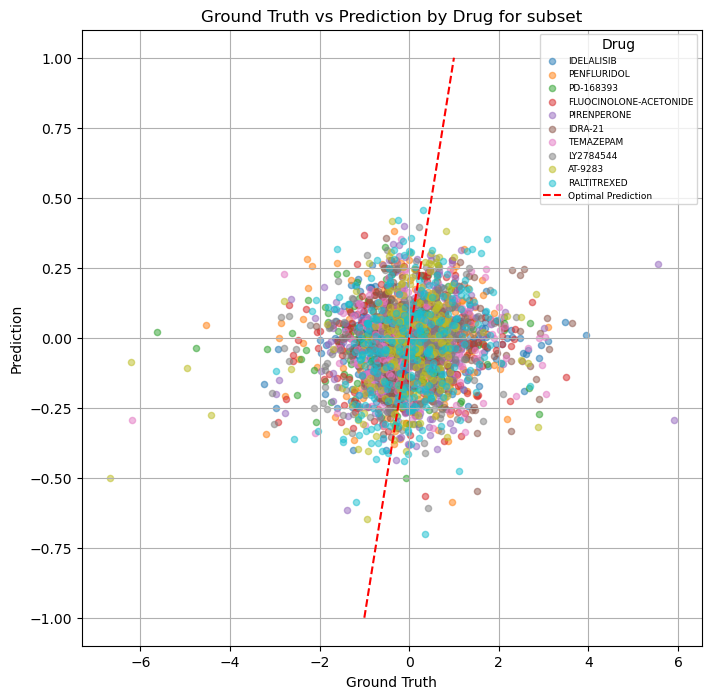

In [25]:
plt.figure(figsize=(8, 8))

# Get unique drugs from the DataFrame
unique_drugs = subset_results_val["drugs"].unique()

# Define colors for each drug
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_drugs)))

# Plot data points for each drug separately
for i, drug in enumerate(unique_drugs):
    data = subset_results_val[subset_results_val["drugs"] == drug]
    plt.scatter(data["ground_truth"], data["prediction"], color=colors[i], label=drug, alpha=0.5, s=20)

# Get min and max values of 'ground_truth' and 'prediction'
min_val = min(subset_results_val["ground_truth"].min(), subset_results_val["prediction"].min())
max_val = max(subset_results_val["ground_truth"].max(), subset_results_val["prediction"].max())

# Draw red diagonal line
plt.plot([-1, 1], [-1, 1], color="red", linestyle="--", label="Optimal Prediction")

plt.title("Ground Truth vs Prediction by Drug for subset")
plt.xlabel("Ground Truth")
plt.ylabel("Prediction")
plt.legend(title="Drug", fontsize=6.5)
plt.grid(True)
plt.show()

/Users/niklaskiermeyer/anaconda3/envs/DruxAI/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/niklaskiermeyer/anaconda3/envs/DruxAI/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


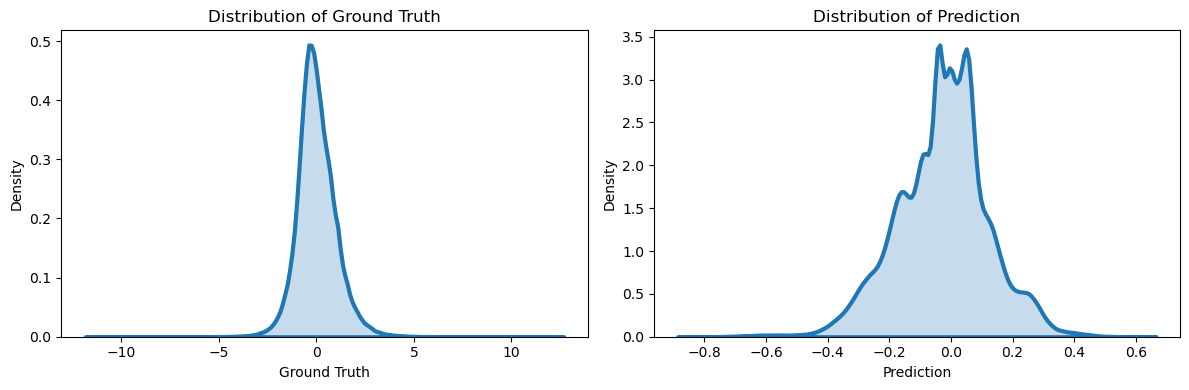

In [27]:
# Create a figure with 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot the distribution of 'ground_truth' on the first subplot
sns.kdeplot(all_results["ground_truth"], fill=True, linewidth=3, ax=axs[0])
axs[0].set_title("Distribution of Ground Truth")
axs[0].set_xlabel("Ground Truth")
axs[0].set_ylabel("Density")

# Plot the distribution of 'prediction' on the second subplot
sns.kdeplot(all_results["prediction"], fill=True, linewidth=3, ax=axs[1])
axs[1].set_title("Distribution of Prediction")
axs[1].set_xlabel("Prediction")
axs[1].set_ylabel("Density")

plt.tight_layout()
plt.show()